#### Dependencies:

In [1]:
from kcat_prediction import *

Before using kcat prediction for the first time, we have to download the ESM-1b model:

In [2]:
import esm
model, alphabet = torch.hub.load("facebookresearch/esm:v0.4.0", "esm1b_t33_650M_UR50S")

Using cache found in C:\Users\marle/.cache\torch\hub\facebookresearch_esm_v0.4.0


Example for calculating kcat prediction. You can enter multiple enyzmes and substrates. Enzyme 1 will be paired with substrates 1/products 1, enzyme 2 will be paired with substrates 2/products 2 and so on...

Enter enzymes as amino acid sequences and substrates/products either as SMILES strings, KEGG Compound IDs, or InChI strings. If the reaction has multiple substrates or products, separate them by using a semicolon (";)

In [3]:
import pandas as pd

organism = "Escherichia coli"

data = pickle.load(open("../data/final_kcat_dataset_" + organism + ".pkl", "rb"))

data['substrates'] = data['substrates'].apply(list)

data['substrates'] = ['#'.join(map(str, l)) for l in data['substrates']]

data['products'] = data['products'].apply(list)

data['products'] = ['#'.join(map(str, l)) for l in data['products']]

# data["log10_kcat"] = [np.log10(x) for x in data["geomean_kcat"]]

# import plotnine
# (plotnine.ggplot(data, plotnine.aes(x="log10_kcat")) + 
#   plotnine.geom_histogram(binwidth=0.1,color='black', fill='white'))

In [4]:
df = kcat_predicton(substrates = data["substrates"].tolist(),
               products = data["products"].tolist(),
               enzymes = data["Sequence"].tolist(),
                values = np.log10(data["geomean_kcat"].tolist()),
                                 RID = data["Reaction ID"].tolist(),
                                 SID = data["Sequence ID"].tolist(),
                       EC = data["ECs"].tolist())

Step 1/3: Calculating numerical representations for all substrates and products.
Step 2/3: Calculating numerical representations for all enzymes.
.....2(a) Loading ESM-1b model.


In [5]:
df.to_pickle('../data/output_' + organism + '.pkl)
df = pd.read_csv('../data/final_output_Escherichia coli.csv')

In [10]:
import sklearn.metrics as sk
import scipy as sci
df = df[df["complete"]==True]
rms = sk.mean_squared_error(df["value"].tolist(), df["kcat [s^(-1)]"].tolist(), squared=False)
R2 = sk.r2_score(df["value"].tolist(), df["kcat [s^(-1)]"].tolist())
Pearson = sci.stats.pearsonr(df["value"].tolist(), df["kcat [s^(-1)]"].tolist())[0]

print(rms, R2, Pearson)

rms = sk.mean_squared_error((10**df["value"]).tolist(), (10**df["kcat [s^(-1)]"]).tolist(), squared=False)
R2 = sk.r2_score((10**df["value"]).tolist(), (10**df["kcat [s^(-1)]"]).tolist())
Pearson = sci.stats.pearsonr((10**df["value"]).tolist(), (10**df["kcat [s^(-1)]"]).tolist())[0]

print(rms, R2, Pearson)

140.06632148769185 0.05456588005896923 0.4204536121364181


In [7]:
data_train = pickle.load(open("../data/train_df_kcat.pkl", "rb"))

In [8]:
df = df.rename(columns={'enzyme': 'Sequence'})

In [9]:
def calculate_identity_ignore_gaps(seq1, seq2):
    identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
    pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
    return pid

In [10]:
from Bio import Align
from Bio.Align import substitution_matrices

df["max_identity"] = np.nan

aligner=Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.mode = "global"
aligner.extend_gap_score = -0.5
aligner.open_gap_score = -10

for i in df.index:
    identities = []
    for j in data_train.index:
        seq1 = str(df["Sequence"][i])
        seq2 = str(data_train["Sequence"][j])
        if 'U' in seq1:
            seq1 = seq1.replace('U', 'C')
        if 'U' in seq2:
            seq2 = seq2.replace('U', 'C')
        try:
            alignments = aligner.align(seq1, seq2)
        except:
            print(seq1, seq2)
        identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
    df["max_identity"][i] = max(identities)

0.45692883895131087
1.0
1.0
0.45692883895131087
0.4618181818181818
0.43661971830985913
0.4277456647398844
0.45161290322580644
0.43564356435643564
0.39509536784741145
0.40310077519379844
0.40310077519379844
0.40310077519379844
0.40310077519379844
0.40310077519379844
0.44672131147540983
0.41975308641975306
0.46691176470588236
0.4353982300884956
0.4353982300884956
0.4353982300884956
0.40487804878048783
0.40487804878048783
0.3425559947299078
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.42779291553133514
0.42779291553133514
0.42779291553133514
0.42779291553133514
0.46938775510204084
0.41346153846153844
0.41975308641975306
0.41346153846153844
0.41975308641975306
0.7024793388429752
0.7024793388429752
0.7024793388429752
1.0
1.0
1.0
1.0
1.0
1.0
0.40487804878048783
0.40487804878048783
0.4004739336492891
0.37790697674418605
0.46502057613168724
0.40445859872611467
1.0
1.0
1.0
0.4065656565656566
0.4065656565656566
0.37790697674418605
0.4250681198910082
0.4250681198910082
0.525679758308157
0.4050632911392405
0.405

In [11]:
df["max_identity"] = df["max_identity"]*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


40
0-40% 0.06328905255922002 1.0904703186498814
224
40-80% 0.06983287815343919 1.0516476264450825
6
80-99% -1.1777506487197966 1.254326731457582
137
99-100% 0.5707978396037854 0.6333644001775149


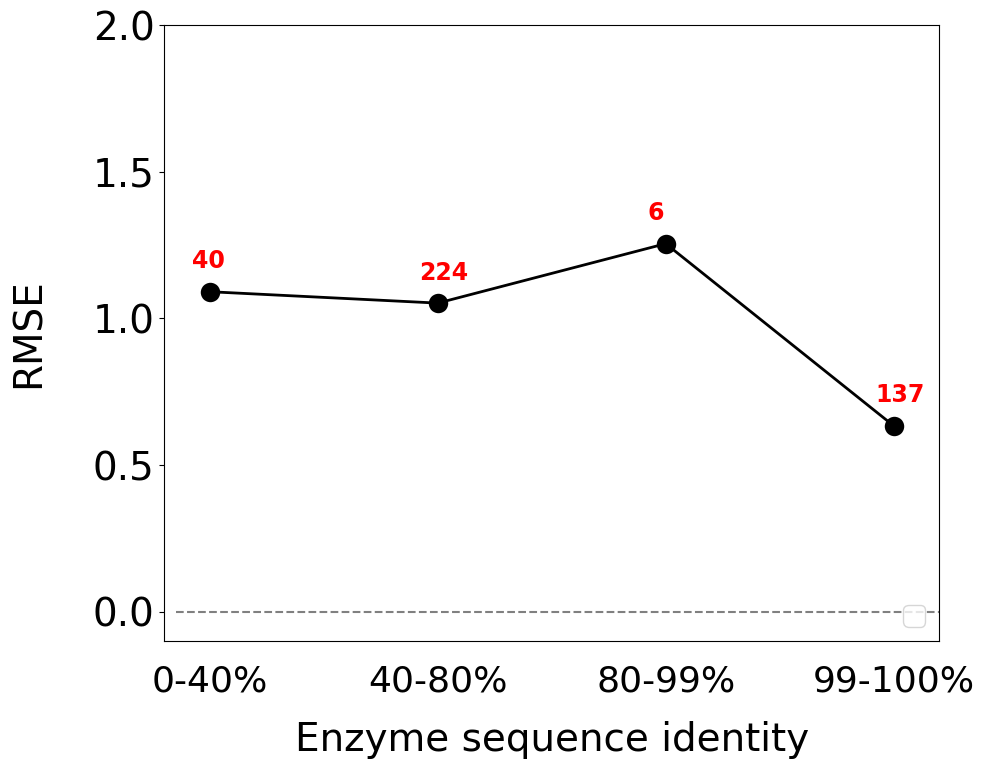

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize= (10,8))
plt.rcParams.update({'font.size': 28})

splits = ["0-40%", "40-80%", "80-99%","99-100%"]
lower_bounds = [0,40,80,99]
upper_bounds = [40,80,99,100]

points1 = []
points2 = []
n_points1, n_points2 = [], []

for i, split in enumerate(splits):

    lb, ub = lower_bounds[i], upper_bounds[i]
    
    help_df = df.loc[df["max_identity"]>= lb].loc[df["max_identity"]<= ub]
    y_true = np.array(help_df["value"])
    y_pred = np.array(help_df["kcat [s^(-1)]"])
    n_kcat = len(y_pred)
    R2 =  sk.r2_score(y_true, y_pred)
    abs_error = abs(y_true - y_pred)
    rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
    print(len(y_true))
    print(split, R2, rmse)
    points1.append(R2)
    points2.append(rmse)
    n_points1.append(n_kcat)


ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

plt.ylim((-0.1,2))
plt.xlim((-0.2, 3.2))
plt.legend(loc = "lower right", fontsize=20)
plt.ylabel('RMSE')
plt.xlabel('Enzyme sequence identity')
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


plt.plot([0,1,2,3], points2, c= "black", linewidth=2)

for i, split in enumerate(splits):
    points1.append(R2)
    
    if i ==0:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

    else:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
plt.savefig(join("..", "data", "sequence_identity.png"))
plt.show()

360


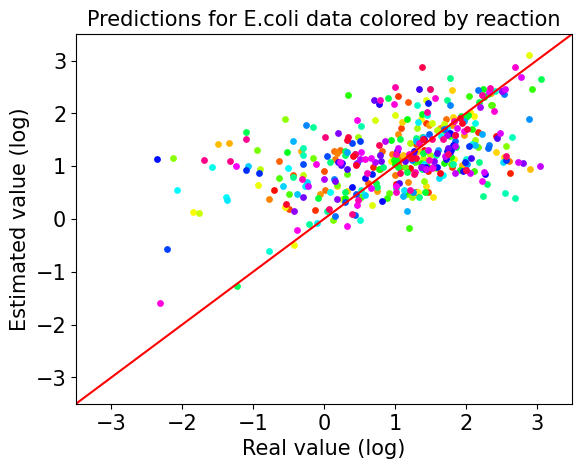

In [7]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt

uniq = list(set(df['Reaction ID']))
z = range(1, len(uniq))
hot = plt.get_cmap('hsv')
cNorm = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

for i in range(len(uniq)):
    indx = df['Reaction ID'] == uniq[i]
    plt.scatter(df["value"][indx], df["kcat [s^(-1)]"][indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
    
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Real value (log)', fontsize=15)
plt.ylabel('Estimated value (log)', fontsize=15)
plt.title('Predictions for E.coli data colored by reaction', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

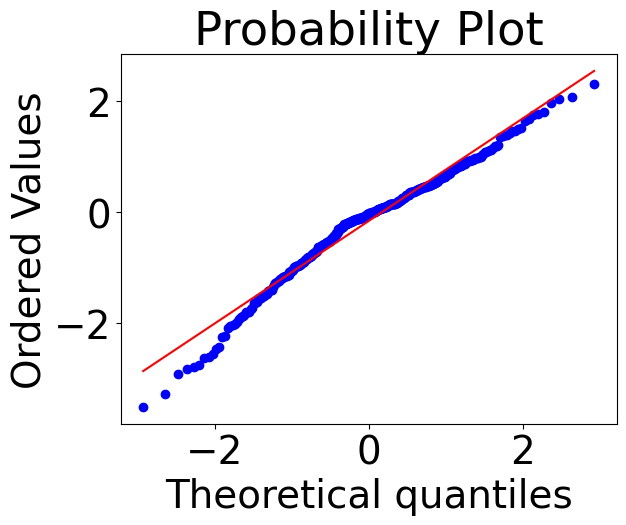

In [14]:
sci.stats.probplot(np.subtract(np.array(df["value"].tolist()), np.array(df["kcat [s^(-1)]"].tolist())), dist="norm", plot=plt)
plt.show()

In [15]:
EC_kcat_pred =[[] for _ in range(6)]
EC_kcat =[[] for _ in range(6)]
for ind in df.index:
    try:
        EC = int(df["EC"][ind][0][0])
        EC_kcat[EC-1].append(df["value"][ind])
        EC_kcat_pred[EC-1].append(df["kcat [s^(-1)]"][ind])
    except IndexError:
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


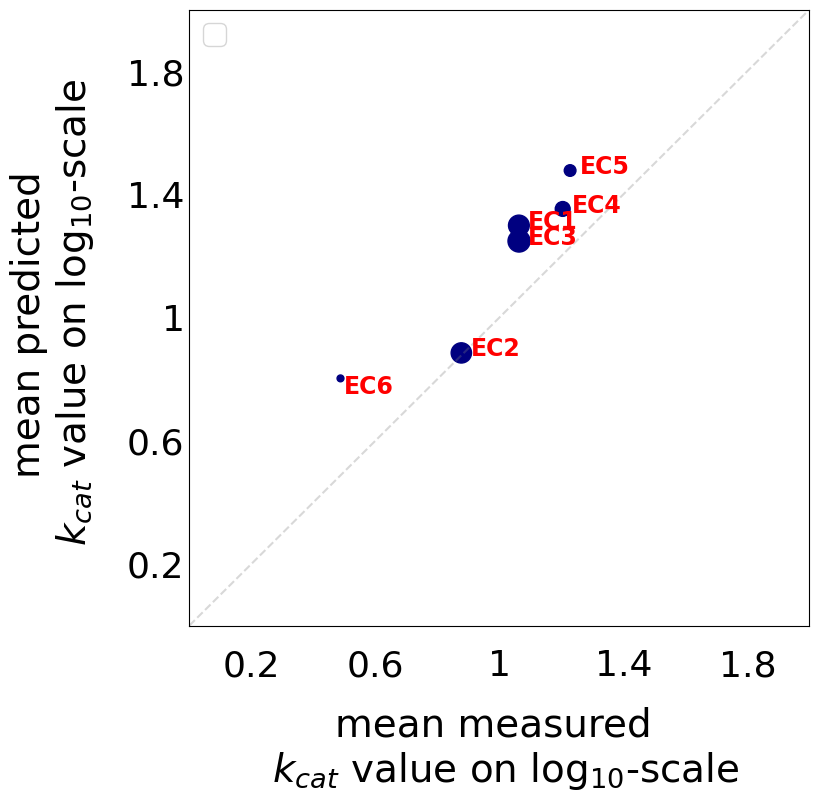

In [16]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

classes = [str(i) for i in range(1,7)]

for i in range(len(EC_kcat)):
    
    circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
                        np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
    ax.add_artist(circle)
    if i ==5:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
    else:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

ticks2 = [0.2, 0.6,1,1.4,1.8]
labs = ticks2
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

ax.set_yticks(ticks2)
ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='y', length=0, rotation = 0)

plt.ylim((0,2))
plt.xlim((0, 2))
plt.legend(loc = "upper left", fontsize=20)
plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
plt.savefig(join("..", "data", "EC_classes_mean_kcat.png"))
plt.show()

In [17]:
import pandas as pd
import numpy as np
from os.path import join
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
CURRENT_DIR = os.getcwd()

mol_folder = join("..", "..", "data", "mol-files")
def get_reaction_site_smarts(metabolites):
    reaction_site = ""
    for met in metabolites:
        is_kegg_id = False
        
        if met[0] == "C":
            is_kegg_id = True
            
        if is_kegg_id:
            try:
                Smarts = Chem.MolToSmarts(Chem.MolFromMolFile(join(mol_folder, met + '.mol')))
            except OSError:
                return(np.nan)
        else:
            mol = Chem.inchi.MolFromInchi(met)
            if mol is not None:
                Smarts = Chem.MolToSmarts(mol)
            else:
                return(np.nan)
        reaction_site = reaction_site + "." + Smarts
    return(reaction_site[1:])

def get_reaction_site_smiles(metabolites):
    reaction_site = ""
    for met in metabolites:
        is_kegg_id = False
        
        if met[0] == "C":
            is_kegg_id = True
            
        if is_kegg_id:
            try:
                Smarts = Chem.MolToSmiles(Chem.MolFromMolFile(join(mol_folder, met + '.mol')))
            except OSError:
                return(np.nan)
        else:
            mol = Chem.inchi.MolFromInchi(met)
            if mol is not None:
                Smarts = Chem.MolToSmiles(mol)
            else:
                return(np.nan)
        reaction_site = reaction_site + "." + Smarts
    return(reaction_site[1:])

def convert_fp_to_array(difference_fp_dict):
    fp = np.zeros(2048)
    for key in difference_fp_dict.keys():
        fp[key] = difference_fp_dict[key]
    return(fp)

In [18]:
df["structural_fp"] = ""

for ind in df.index:
    substrates = df["substrates"][ind].split('#')
    products = df["products"][ind].split('#')
    left_site = get_reaction_site_smarts(substrates)
    right_site = get_reaction_site_smarts(products)
    if not pd.isnull(left_site) and not pd.isnull(right_site):
        rxn_forward = AllChem.ReactionFromSmarts(left_site + ">>" + right_site)
        structural_fp = Chem.rdChemReactions.CreateStructuralFingerprintForReaction(rxn_forward).ToBitString()
    df["structural_fp"][ind] = structural_fp

In [24]:
import scipy

train_fps = [np.array(list(data_train["structural_fp"][ind][:3276])).reshape(1,-1).astype(int) for ind in data_train.index]
test_fps = [np.array(list(df["structural_fp"][ind][:3276])).reshape(1,-1).astype(int) for ind in df.index]

max_sim = []

for fp in test_fps:
    jaccard_sim = np.array([1- scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
    max_sim.append(np.max(jaccard_sim))
    
df["reaction_sim"] = max_sim

df["reaction_sim"]= (df["reaction_sim"] - np.min(df["reaction_sim"]))
df["reaction_sim"] = df["reaction_sim"]/np.max(df["reaction_sim"])


In [25]:
df["global_sim"] = (df["max_identity"]/100)*df["reaction_sim"]

0.0 - 0.4 0.5905484191656359 0.9203452644252985 0.657619869789483 4
0.4 - 0.8 0.3574372270869951 0.6059550677057842 0.982553266718025 67
0.8 - 1 0.15445757274940985 0.45877435566751357 0.9342776552115797 336


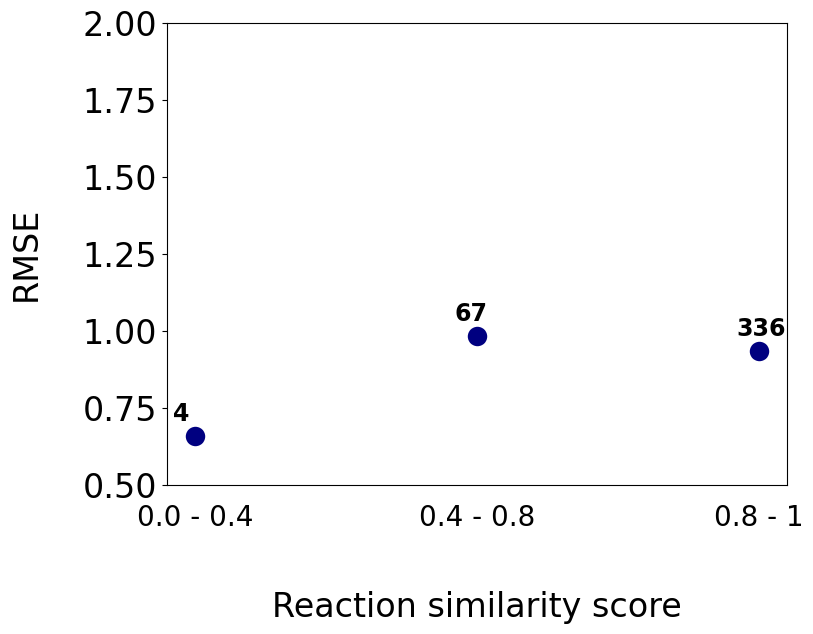

In [16]:
import matplotlib.pyplot as plt
import math
help_df = df

sim_bins_lb = [0.0, 0.4, 0.8]
sim_bins_ub = [0.4, 0.8, 1]
r2_scores, n_points, pearson_r, rmse = [], [], [], []
for i in range(len(sim_bins_lb)):
    help_df2 = help_df.loc[help_df["reaction_sim"] <= sim_bins_ub[i]].loc[help_df["reaction_sim"] >= sim_bins_lb[i]]
    pred = np.array(help_df2["kcat [s^(-1)]"])
    true = np.array(help_df2["value"])
    r2_scores.append(sk.r2_score(true, pred))
    pearson_r.append(sci.stats.pearsonr(true, pred)[0])
    rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
    n_points.append(len(pred))
    print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(figsize= (8,6))

for i in range(len(sim_bins_lb)):    
    plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
    ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
plt.xlabel('Reaction similarity score')
plt.ylabel('RMSE')
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5,-0.23)

ticks2 = np.array(range(len(sim_bins_lb)))
labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
ax.tick_params(axis='x', length=0, rotation = 0)

plt.ylim((0.5,2))
plt.show()

In [44]:
df.to_pickle('../data/final_output_' + organism + '.pkl')

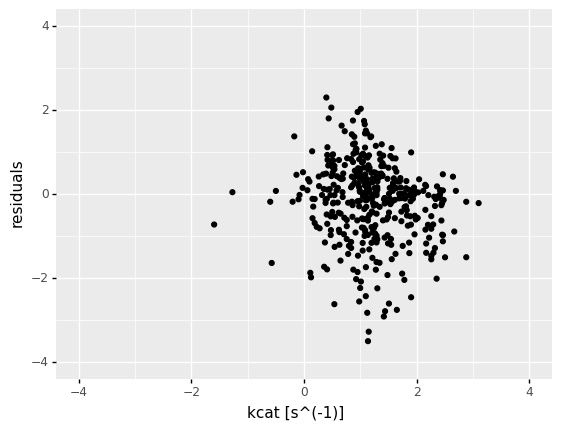

<ggplot: (-9223371900153708140)>

In [8]:
import plotnine 

(plotnine.ggplot(df, plotnine.aes(sample = "value")) +
plotnine.stat_qq() +
plotnine.stat_qq_line())

(plotnine.ggplot(df, plotnine.aes(sample = "value"-"kcat [s^(-1)]")) +
plotnine.stat_qq() +
plotnine.stat_qq_line())